<a href="https://colab.research.google.com/github/gtbook/gtsam-examples/blob/main/KalmanSmootherExample.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Kalman Smoother

GTSAM is based on sparse factorization, which it implements by elimination of a Gaussian factor graph. A Kalman smoother is a simple *linear* Markov chain, with Gaussian measurements and Gaussian Motion models, and as a result GTSAM simply eats through it, like a knife through butter.

In [23]:
%pip -q install gtbook # also installs latest gtsam pre-release

Note: you may need to restart the kernel to use updated packages.


In [24]:
import math
import matplotlib.pyplot as plt
import numpy as np

import gtsam
import gtsam.utils.plot as gtsam_plot
from gtbook.display import show
from gtbook.gaussian import sample_bayes_net
from gtsam import Point2, noiseModel

# Some keys we use below:
x1, x2, x3 = [gtsam.symbol('x', i) for i in [1, 2, 3]]

## A Simple Kalman Smoother Example

We illustrate this with a simple 3-state Kalman smoother. It also shows how the solution the Kalman smoother is a Bayes net, which exactly captures the Gaussian posterior.

We first set up a small `GaussianFactorGraph`. I like specifying factors in this case with a `gtsam.JacobianFactor`:

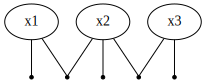

In [25]:
gfg = gtsam.GaussianFactorGraph()

# add "measurements" |x1|^2, |x2-(2,0)|^2, |x3-(4,0)|^2
model2 = noiseModel.Isotropic.Sigma(2, 0.5)
I2 = np.eye(2, dtype=float)
for i, key in enumerate([x1, x2, x3]):
    gfg.add(gtsam.JacobianFactor(i1=key, A1=I2,
            b=gtsam.Point2(i*2, 0), model=model2))  # prior

# add "motion models" |x2 - x1 - (2,0)|^2, |x3 - x2 - (2,0)|^2
motion_model = noiseModel.Diagonal.Sigmas([0.1,0.3])
for i1, i2 in [(x1, x2), (x2, x3)]:
    gfg.add(gtsam.JacobianFactor(i1=i1, A1=-I2, i2=i2, A2=I2,
            b=gtsam.Point2(2, 0), model=motion_model))  # between x1 and x2

show(gfg)


Solving this with GTSAM is trivial, and because in this case the measurements and motion models agree perfectly, the solution has zero error:

In [26]:
smoother_solution = gfg.optimize()
print(f"solution = {smoother_solution} with error {gfg.error(smoother_solution):.2f}")

solution = VectorValues: 3 elements
  x1: 2.56205e-15           0
  x2: 2 0
  x3: 4 0
 with error 0.00


## The Posterior as a Bayes Net

The way GTSAM solves this is by eliminating $x_1$, then $x_2$, and then $x_3$, yielding a Bayes net made up of Gaussian Conditionals. We can call `eliminateSequential` to obtain the Bayes net to visualize it:

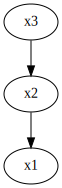

In [27]:
gbn = gfg.eliminateSequential()
show(gbn)

The Bayes net is *equivalent* to an upper triangular matrix $R$, which we can explicitly produce. This produces a dense matrix, but that's OK in this small example:

In [28]:
R, d = gbn.matrix()
print(np.round(R,2))

[[10.2   0.   -9.81  0.    0.    0.  ]
 [ 0.    3.89  0.   -2.86  0.    0.  ]
 [ 0.    0.   10.38  0.   -9.63  0.  ]
 [ 0.    0.    0.    4.25  0.   -2.62]
 [ 0.    0.    0.    0.    3.36  0.  ]
 [ 0.    0.    0.    0.    0.    2.88]]


The $d$ above is the "square root information vector", as the Bayes net defines the following quadratic, and corresponding Gaussian density, in this case in $\mathbb{R}^6$:

$$
E_{gbn}(x; R, d) \doteq \frac{1}{2} \|Rx - d\|^2
$$

$$
\mathcal{N}_{gbn}(x; R, d) \sim k \exp \{- \frac{1}{2} \|Rx - d\|^2\}
$$

## Marginals, the Hard Way

The mean of this Gaussian is $\mu=R^{-1}d$ and its covariance $P=(R^TR)^{-1}$. The latter allows us to obtain and plot the marginals:

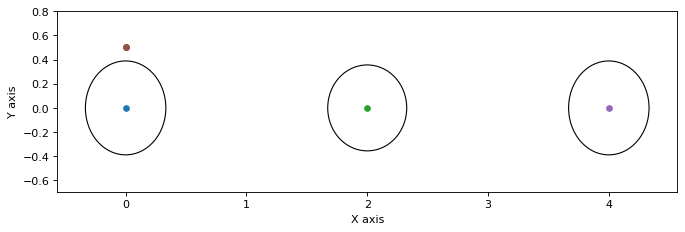

In [29]:
P = np.linalg.inv(R.T @ R) # full 6*6 covariance matrix

def gaussian_figure():
    plt.figure(0, figsize=(10, 3), dpi=80)
    for i, key in enumerate([x1, x2, x3]):
        gtsam_plot.plot_point2(0, smoother_solution.at(key), 0.5, P[i*2:(i+1)*2,i*2:(i+1)*2])

    plt.axis('equal')

gaussian_figure()

## Efficient Marginals using the Bayes Tree

The above approach to obtain the covariance $P$ is very expensive if $x$ is high dimensional.
Note that there are better ways to obtain the marginals, and this is implemented by the Bayes tree, which we can obtain by *multi-frontal* elimination instead:

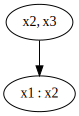

In [30]:
bayes_tree = gfg.eliminateMultifrontal()
show(bayes_tree)

The above shows the *Bayes tree*, which is a directed tree of cliques. The undirected version of this is known as the *clique tree* or *junction tree*. One of the "hidden secrets" of GTSAM is that it has a very efficient way of calculating the marginals in a Bayes tree:

In [31]:
for key in [x1,x2,x3]:
    print(f"{gtsam.DefaultKeyFormatter(key)}:\n{bayes_tree.marginalCovariance(key)}\n")

x1:
[[0.08868927 0.        ]
 [0.         0.12088585]]

x2:
[[0.08552632 0.        ]
 [0.         0.10119048]]

x3:
[[0.08868927 0.        ]
 [0.         0.12088585]]



It can even compute arbitrary *joint* marginals for any two variables:

In [32]:
Q, _ = bayes_tree.joint(x1,x3).hessian()
print(np.linalg.inv(Q))

[[0.08868927 0.         0.07907389 0.        ]
 [0.         0.12088585 0.         0.05470938]
 [0.07907389 0.         0.08868927 0.        ]
 [0.         0.05470938 0.         0.12088585]]


## Sampling

Bayes nets support efficient ancestral sampling, which produces samples from the *joint* as a dictionary:

In [44]:
for key, sample in sample_bayes_net(gbn, 5).items():
    print(f"{gtsam.DefaultKeyFormatter(key)}:\n{sample}")

x3:
[[ 3.6705878   3.88893272  3.83042208  4.12003342  4.06887363]
 [-0.61452742 -0.29320621 -0.31707716  0.32888676  0.3223772 ]]
x2:
[[ 1.80990343  2.04199632  1.83391218  1.95109233  2.03068529]
 [-0.25723145 -0.20697782 -0.14554712  0.91539008  0.38438762]]
x1:
[[-0.27239206 -0.02694265 -0.27249132  0.08177796  0.00249314]
 [-0.5672486   0.59338444 -0.00698812  0.65979105 -0.16992028]]


It is fast, as sampling is done batch-wise, e.g., for batch-size $N=1000$:

In [34]:
%%timeit
samples = sample_bayes_net(gbn, 1000)

387 µs ± 3.68 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


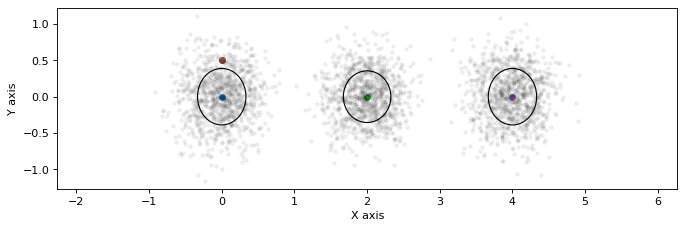

In [46]:
gaussian_figure()
for key, points in sample_bayes_net(gbn, 1000).items():
    plt.plot(points[0], points[1], 'k.', alpha=0.05)

## Conclusion

Kalman smoothers are easy. Kalman filters are actually harder to implement, but we also did that for you, in `gtsam.KalmanFilter` and `gtsam.ExtendedKalmanFilter`.